In [1]:
#importing the libraries

import re
import string
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from time import time, sleep
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import numpy as np
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import en_core_web_sm
    nlp = en_core_web_sm.load()

In [2]:
# Apply first round of text cleaning techniques
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    #get rid of non english charectors
    text = re.sub("([^\x00-\x7F])+","",text)
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [3]:
# function to find the most frequent values in a column and their frequencies
from collections import Counter
def most_commons(df, cl_name, n=10):
    return pd.DataFrame(Counter(df[cl_name]).most_common(n), columns=[cl_name, 'frequency'])

In [4]:
#importing the data
data = pd.read_csv('data/preprocessedData.csv')

In [5]:
# # make a new df to store hashtag results
# columns=['text_index', 'hashtag', 'company']
# data_hashtags = pd.DataFrame(columns=columns)
# # convert df to array to improve loop time performance
# hashtag_list = data['hashtags'].values
    
# for i in data.index:
#     # to improve loop time performance, convert integer to string
# #     hashtag_list = hashtag_list[i].translate(trantab).split()
#     temp = [[str(i), hashtag] for hashtag in hashtag_list[i]]
#     temp_df = pd.DataFrame(temp, columns=columns[:-1])
#     temp_df[columns[-1]] = data.loc[i, columns[-1]]
#     # add 1 row for each hashtag result
#     data_hashtags = data_hashtags.append(temp_df, ignore_index=True)
    
# data_hashtags.head(2)

In [6]:
# data_hashtags

In [7]:
# data_hashtags.to_csv('data/data_hashtags.csv', index=False)
data_hashtags = pd.read_csv('data/data_hashtags.csv')

In [8]:
data_hashtags['hashtag'] = pd.DataFrame(data_hashtags['hashtag'].apply(round1))
#Replacing the empty texts with numpy nan and removing them
data_hashtags['hashtag'].replace('', np.nan, inplace=True)
data_hashtags.dropna(subset=['hashtag'], inplace=True)

data_hashtags

,text_index,hashtag,company
0,9,totok,Apple
1,12,fbi,Apple
2,15,entrepreneur,Apple
3,15,respect,Apple
5,31,biggestdisappointment,Apple
...,...,...,...
23958,34597,huaweifit,Huawei
23959,34597,huaweitalia,Huawei
23961,34597,huaweipicture,Huawei
23962,34597,huaweipvf,Huawei


In [9]:
# top most frequently mentioned named entities
most_commons(data_hashtags.loc[data_hashtags['company']=='Apple', ['hashtag']], 'hashtag', 10)

,hashtag,frequency
0,apple,181
1,iphone,105
2,itunes,49
3,ios,36
4,airpodspro,31
5,shotoniphone,27
6,applewatch,25
7,music,23
8,applemusic,20
9,ipad,20


In [10]:
# dict to map hashtag names with the same meaning
hashtag_name_map = {'Apple': 'apple', 
                   'apples': 'apple',
                    'Iphone': 'iPhone',
                    'iphones':'iPhone',
                    'airpodspro':'airpods',
                    'macbookpro':'macbook',
                    'mac':'macbook',
                    'catalina':'macos',
                    'macpro':'macbook',
                    'music':'applemusic',
                    'ipadpro':'ipad'
                  }

# map the hashtag names
for hashtag in hashtag_name_map.keys():
    data_hashtags.loc[data_hashtags['hashtag']==hashtag, 'hashtag'] = hashtag_name_map[hashtag]

# top most frequently mentioned named entities
most_commons(data_hashtags.loc[data_hashtags['company']=='Apple', ['hashtag']], 'hashtag', 10)

,hashtag,frequency
0,apple,181
1,iphone,105
2,macbook,57
3,airpods,50
4,itunes,49
5,applemusic,43
6,ios,36
7,macos,34
8,ipad,28
9,shotoniphone,27


In [11]:

# top most frequently mentioned named entities
most_commons(data_hashtags.loc[data_hashtags['company']=='Samsung', ['hashtag']], 'hashtag', 10)

,hashtag,frequency
0,samsung,488
1,jollyjohn,254
2,galaxybuds,232
3,galaxynote,127
4,galaxy,96
5,ai,95
6,android,68
7,tech,68
8,technology,59
9,samsunggalaxy,52


In [12]:
# dict to map hashtag names with the same meaning
hashtag_name_map = {'samsunggalaxy': 'galaxy', 
                    'withgalaxy': 'galaxy'
                  }

# map the hashtag names
for hashtag in hashtag_name_map.keys():
    data_hashtags.loc[data_hashtags['hashtag']==hashtag, 'hashtag'] = hashtag_name_map[hashtag]

# top most frequently mentioned named entities
most_commons(data_hashtags.loc[data_hashtags['company']=='Samsung', ['hashtag']], 'hashtag', 10)

,hashtag,frequency
0,samsung,488
1,jollyjohn,254
2,galaxybuds,232
3,galaxy,193
4,galaxynote,127
5,ai,95
6,android,68
7,tech,68
8,technology,59
9,tron,52


In [13]:
# top most frequently mentioned named entities
most_commons(data_hashtags.loc[data_hashtags['company']=='Huawei', ['hashtag']], 'hashtag', 10)

,hashtag,frequency
0,huawei,489
1,china,123
2,ai,90
3,technology,72
4,tech,62
5,iot,49
6,ccp,48
7,websummit,45
8,trustintech,43
9,boycotthuawei,39


In [14]:
# dict to map hashtag names with the same meaning
hashtag_name_map = {'tech': 'technology', 
                    'chinazi': 'china',
                    'trustintech': 'technology',
                    'boycottchina': 'boycotthuawei',
                    'digital': 'technology',
                    'digitaltransformation': 'IOT',
                    'iot': 'IOT',
                    'cloud': 'IOT'
                  }

# map the hashtag names
for hashtag in hashtag_name_map.keys():
    data_hashtags.loc[data_hashtags['hashtag']==hashtag, 'hashtag'] = hashtag_name_map[hashtag]

# top most frequently mentioned named entities
most_commons(data_hashtags.loc[data_hashtags['company']=='Huawei', ['hashtag']], 'hashtag', 10)

,hashtag,frequency
0,huawei,489
1,technology,208
2,china,158
3,IOT,109
4,ai,90
5,boycotthuawei,77
6,ccp,48
7,websummit,45
8,us,32
9,huaweieunewshttps,31


In [15]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

def barchart_hashtags(hashtags,title):
    
    temp_hash = hashtags.hashtag.tolist()
    temp_freq = hashtags.frequency.tolist()

    y_pos = np.arange(len(temp_hash))

    plt.barh(y_pos, temp_freq, align='center', alpha=0.5 , 
             color=['black', 'red', 'green', 'blue', 'cyan','magenta','yellow','Purple','orange','Brown'])
    plt.yticks(y_pos, temp_hash)
    plt.xlabel('count')
    plt.title(title)

    plt.show()
    
    

In [16]:
top_ten_Apple_hashtags = most_commons(data_hashtags.loc[data_hashtags['company']=='Apple', ['hashtag']], 'hashtag', 10)
top_ten_Samsung_hashtags = most_commons(data_hashtags.loc[data_hashtags['company']=='Samsung', ['hashtag']], 'hashtag', 10)
top_ten_huawei_hashtags = most_commons(data_hashtags.loc[data_hashtags['company']=='Huawei', ['hashtag']], 'hashtag', 10)

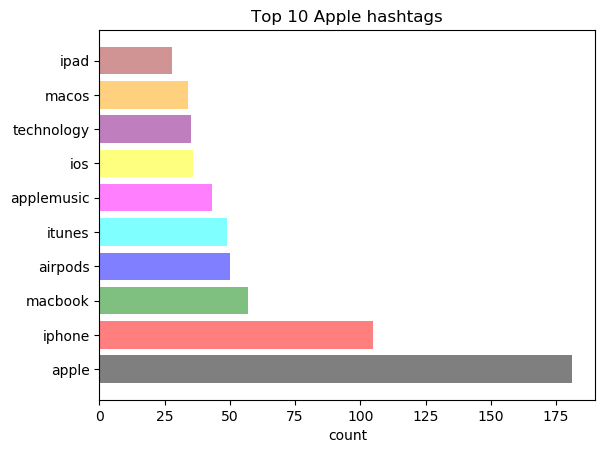

In [17]:
barchart_hashtags(top_ten_Apple_hashtags,'Top 10 Apple hashtags')

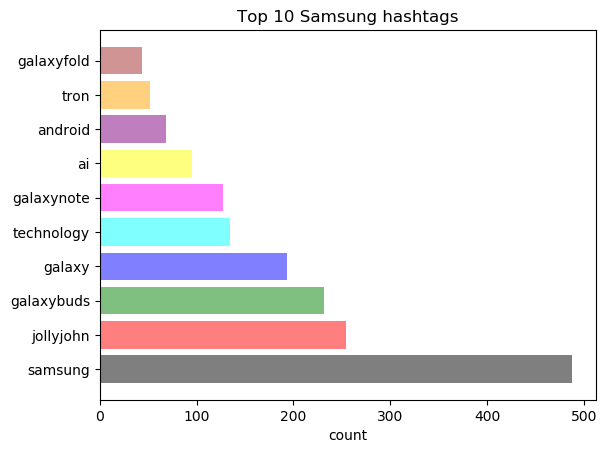

In [18]:
barchart_hashtags(top_ten_Samsung_hashtags,'Top 10 Samsung hashtags')

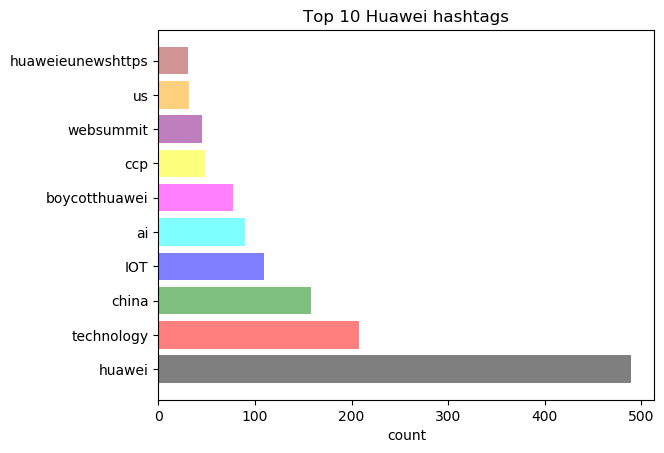

In [19]:
barchart_hashtags(top_ten_huawei_hashtags,'Top 10 Huawei hashtags')

In [20]:
# plot word cloud of a given text
def plot_word_cloud(words, colormap='bwr', title=None, width=1000, height=800):
    # set the stop words
    stopwords = set(STOPWORDS)
    Additional_stop_words = ['']
    for s in  Additional_stop_words:
        stopwords.add(s)

    # generate WordCloud
    if type(words)==str:
        wc = WordCloud(background_color="white", stopwords=stopwords, 
                       width=width, height=height, colormap=colormap).generate(words)
    # for simplicity, I assume that if words is not an string, it is a dictionary of word frequencies
    else:
        wc = WordCloud(background_color="white", stopwords=stopwords, 
                       width=width, height=height, colormap=colormap).generate_from_frequencies(words)

    # show the WordCloud
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=25, y=1.01)


# plot three word cloud, one for each company
def plot_three_word_clouds(df, title=None, method='str',**kwargs):
    my_color_map = ['Greens','Blues', 'Reds']
    plt.figure(figsize=(20, 10))
    for i, p in enumerate(['Apple', 'Samsung', 'Huawei']):
        if method=='str':
            words = (' '.join(df.loc[df['company']==p, 'text'])).lower()
        # for simplicity, I assume that if not string, the method is word frequency
        else:
            words = Counter(df.loc[df['company']==p, 'entity'])
            
        plt.subplot(1, 3, i+1)
        plot_word_cloud(words, my_color_map[i], title=p, **kwargs)

    if title:
        plt.suptitle(title, fontsize=35, y=0.9)
    
    plt.subplots_adjust(wspace=0.1)
    plt.show()

In [21]:
# plot three word cloud, one for each company
def plot_three_word_clouds_hashtags(df, title=None, method='str',**kwargs):
    my_color_map = ['Greens','Blues', 'Reds']
    plt.figure(figsize=(20, 10))
    for i, p in enumerate(['Apple', 'Samsung', 'Huawei']):
        if method=='str':
            words = (' '.join(df.loc[df['company']==p, 'hashtag'])).lower()
        # for simplicity, I assume that if not string, the method is word frequency
        else:
            words = Counter(df.loc[df['company']==p, 'entity'])
            
        plt.subplot(1, 3, i+1)
        plot_word_cloud(words, my_color_map[i], title=p, **kwargs)

    if title:
        plt.suptitle(title, fontsize=35, y=0.9)
    
    plt.subplots_adjust(wspace=0.1)
    plt.show()

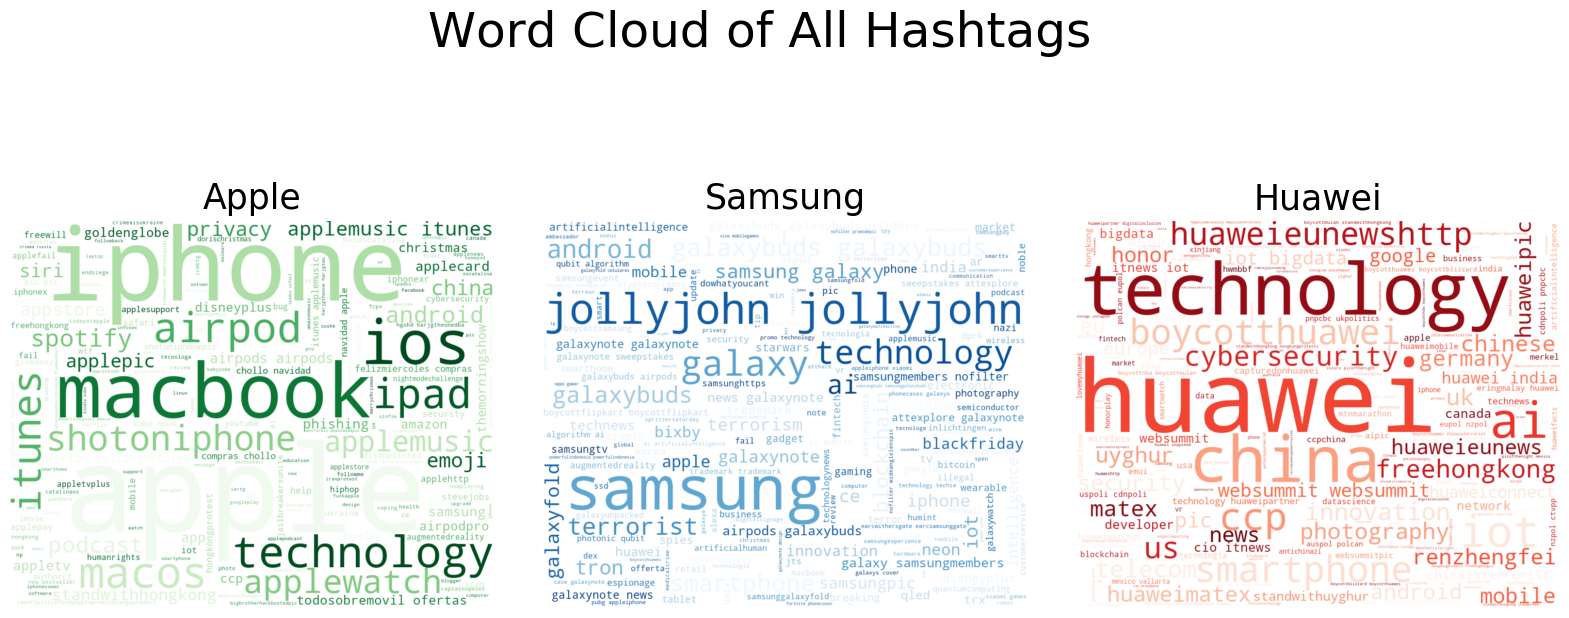

In [22]:
plot_three_word_clouds_hashtags(data_hashtags,'Word Cloud of All Hashtags')

In [23]:
import json

# a_file = open("emotions_map.txt", "w")
# json.dump(emotions_map, a_file)
# a_file.close()
# a_file = open("emotions_map.txt", "r")
with open("emotions_map.txt") as f:
    emotions_map = json.load(f)

In [24]:
# make a new df to store emotions results
columns=['text_index', 'emotion', 'company']
data_emotions = pd.DataFrame(columns=columns)
# convert df to array to improve loop time performance
tokenized_lists = data['tokenizedWords'].values
# for every sentence, run NER and store the result
for i in data.index:
    # to improve loop time performance, convert integer to string
    temp = [[str(i), emotions_map[word]] for word in tokenized_lists[i] if word in emotions_map.keys()]
    temp_df = pd.DataFrame(temp, columns=columns[:-1])
    temp_df[columns[-1]] = data.loc[i, columns[-1]]
    # add 1 row for each NER result
    data_emotions = data_emotions.append(temp_df, ignore_index=True)

In [25]:
#importing NRC emotion lexicons
import joblib
emotion_lexicons = joblib.load( 'emotion_lexicons_dict.pkl')

In [26]:
wordList = emotion_lexicons.items()
NRCWordsList = [(k,v) for k,v in emotion_lexicons.items()]

In [27]:
newDF = pd.DataFrame(columns=['text_index', 'emotion', 'company', "word"])
TempEmotions = []

In [28]:
def processWord(word, ind):
    for item in NRCWordsList:
        if word in item[1]:
            TempEmotions.append((ind,item[0],word, data.company[ind]))

In [ ]:
for ind, lst in enumerate(tokenized_lists):
    for word in lst:
        processWord(word, ind)

In [ ]:
NRCemotions = pd.DataFrame(TempEmotions, columns=['text_index', 'emotion', "word",  'company'])
NRCemotions.head(100)

In [ ]:
NRCemotions.to_csv('data/NRCemotions.csv', index=False)
NRCemotions = pd.read_csv('data/NRCemotions.csv')
NRCemotions

In [ ]:
data_emotions.to_csv('data/data_emotions.csv', index=False)
data_emotions = pd.read_csv('data/data_emotions.csv')
data_emotions

In [ ]:
data_emotions[['company','emotion']].count()

In [ ]:
def emotions_piechart(df,label):
    temp_label = df.emotion.tolist()
    plt.figure(figsize=(25, 8))
    # plt.subplot(1, 3, i+1)
    plt.pie(df['frequency'],
            explode=[0.03, 0.03, 0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03],
            labels=temp_label,
    #         colors=['#daf202', '#09e355', '#95bdb5' ,'#8288ed','#38BF6F','#38BF6F','#38BF6F','#38BF6F','#38BF6F','#38BF6F'],
            autopct='%.1f%%', shadow=True, textprops={'fontsize': 15})
    plt.axis('equal')
    plt.title(label, fontsize=20, y=1)

#     if title:
#         plt.suptitle(title, fontsize=25, y=0.96)

#     plt.subplots_adjust(wspace=0.2)
    plt.show()


In [ ]:
top_10_emotions = most_commons(data_emotions,'emotion',10)
top_10_apple_emotions = most_commons(data_emotions.loc[data_emotions.company == "Apple"],'emotion',10)
top_10_samsung_emotions = most_commons(data_emotions.loc[data_emotions.company == "Samsung"],'emotion',10)
top_10_huawei_emotions = most_commons(data_emotions.loc[data_emotions.company == "Huawei"],'emotion',10)

In [ ]:

top_10_NRCemotions = most_commons(NRCemotions,'emotion',10)
top_10_apple_NRCemotions = most_commons(NRCemotions.loc[NRCemotions.company == "Apple"],'emotion',10)
top_10_samsung_NRCemotions = most_commons(NRCemotions.loc[NRCemotions.company == "Samsung"],'emotion',10)
top_10_huawei_NRCemotions = most_commons(NRCemotions.loc[NRCemotions.company == "Huawei"],'emotion',10)

In [ ]:
most_commons(NRCemotions,'emotion',100)

In [ ]:
emotions_piechart(top_10_NRCemotions,'Tweets Emotions')

In [ ]:
emotions_piechart(top_10_emotions,'Tweets Emotions')

In [ ]:
emotions_piechart(top_10_apple_NRCemotions,'Apple Tweets Emotions')

In [ ]:
emotions_piechart(top_10_apple_emotions,'Apple Tweets Emotions')


In [ ]:
emotions_piechart(top_10_samsung_NRCemotions,'Samsung Tweets Emotions')

In [ ]:
emotions_piechart(top_10_samsung_emotions,'Samsung Tweets Emotions')

In [ ]:
emotions_piechart(top_10_huawei_NRCemotions,'Huawei Tweets Emotions')

In [ ]:
emotions_piechart(top_10_huawei_emotions,'Huawei Tweets Emotions')

In [ ]:
# function to find the most frequent values in a column and their frequencies
from collections import Counter
def most_commons(df, cl_name, n=10):
    return pd.DataFrame(Counter(df[cl_name]).most_common(n), columns=[cl_name, 'frequency'])

# top most frequently mentioned named entities
most_commons(data_hashtags.loc[data_hashtags['company']=='Apple', ['hashtag']], 'hashtag', 50)

In [ ]:
NumaricData = data.groupby('company')[['likes', 'retweets', 'replies']].sum()
NumaricData['company'] = NumaricData.index
NumaricData

In [ ]:
ax = sns.scatterplot(x="likes", y="retweets",
                     hue="company", 
                     size="replies",
                     sizes=(5000, 8000),
                     data=NumaricData)
plt.xlim([50000,110000])
plt.ylim([5000,30000])
plt.legend().set_visible(False)

In [ ]:
sns.countplot(x= 'company',data = data)

In [ ]:
# plot the lenght of tweets given by each user for each company
def plot_word_counts(df, category='company', title=None, figsize=(12,6), suptitle_y=0.95): 
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    plt.suptitle(title, fontsize=20, y=suptitle_y)

    # dictionary to map colors to each company
    my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 

    # violin plot to show the distribution of the word count
    sns.violinplot(x="word_count", y=category,
                   data=df, split=True, palette=my_palette, ax=axs[0])
    axs[0].legend().set_visible(False)
    axs[0].set_ylabel('')

    # bar plot to show the average word count
    sns.barplot(x="word_count", y=category, 
                   data=df, palette=my_palette, ax=axs[1])
    axs[1].set_yticks([])
    axs[1].set_ylabel('')
    axs[1].set_xlabel('mean_word_count')

    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [ ]:
plot_word_counts(data)

In [ ]:
x = data.loc[data['company']=='Apple', 'word_count']
y = data.loc[data['company']=='Samsung', 'word_count']
z = data.loc[data['company']=='Huawei', 'word_count']
sns.kdeplot(x,shade= True,label='Apple')
sns.kdeplot(y,shade= True,label='Samsung')
sns.kdeplot(z,shade= True,label='Huawei')
plt.legend();

In [ ]:
x

In [ ]:
all_words = ' '.join([text for text in data['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
plot_three_word_clouds(data, 'Word Cloud of All')

In [ ]:
def isNotNull(value):
    return value is not None and len(value)>0

In [ ]:
# Importing binglu words
bing_dict_pos = []
bing_dict_neg = []
f = open('negative-words.txt','r')
for line in f:
    t= line.strip().lower();
    if (isNotNull(t)):
        bing_dict_neg.append(t)
f.close()

f = open('positive-words.txt','r')
for line in f:
    t = line.strip().lower();
    if (isNotNull(t)):
        bing_dict_pos.append(t)
f.close()

In [ ]:
from nltk import word_tokenize

def sentiment_bingliu(text):
    sentiment = []
    tokens = nltk.word_tokenize(text)
    pos_cnt = 0
    neg_cnt = 0
    for token in bing_dict_neg:
        if (token in tokens):
            neg_cnt = neg_cnt +1
    for token in bing_dict_pos:
        if (token in tokens):
            pos_cnt = pos_cnt +1
    sentiment.append(pos_cnt - neg_cnt) 
    
    if sentiment[0] == 0:
        return 0
    if sentiment[0] > 0:
        return 1
    if sentiment[0] < 0:
        return -1

In [ ]:
data['bingliuSentiment'] =data['text']
for i in range(len(data['text'])):
    data['bingliuSentiment'][i] = sentiment_bingliu(data['text'][i])

In [ ]:
from nltk.corpus import sentiwordnet as swn
# nltk.download('sentiwordnet')
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

def penn_to_wn(tag):
# Convert between the PennTreebank tags to simple Wordnet tags
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
# nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

def sentiment_sentiwordnet(text):
#     text = text.decode("utf-8")
    raw_sentences = sent_tokenize(text)
    sentiment = 0
    tokens_count = 0

    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))

        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue

            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue

            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue

            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            word_sent = swn_synset.pos_score() - swn_synset.neg_score()

            if word_sent != 0:
                sentiment += word_sent
                tokens_count += 1

    if tokens_count == 0:
        return 0
    sentiment = sentiment/tokens_count
    if sentiment >= 0.01:
        return 1
    if sentiment <= -0.01:
        return -1
    return 0

In [ ]:
import nltk
# nltk.download('averaged_perceptron_tagger')

data['WordNetSentiment'] =data['text']
for i in range(len(data['text'])):
    data['WordNetSentiment'][i] = sentiment_sentiwordnet(data['text'][i])

In [ ]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

data['AfinnSentiment'] =data['text']
for i in range(len(data['text'])):
    data['AfinnSentiment'][i] = af.score(data['text'][i])
    
data

In [ ]:
#calculating the polarity and subjectivity using textblob
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['TextBlobPolarity'] = data['text'].apply(pol)
data['TextBlobSubjectivity'] = data['text'].apply(sub)
data

In [ ]:
#converting the sentiments into same units
flot = lambda x: float(x)
data['WordNetSentiment'] = data['WordNetSentiment'].apply(flot)
data['AfinnSentiment'] = data['AfinnSentiment'].apply(flot)
data['bingliuSentiment'] = data['bingliuSentiment'].apply(flot)

In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 10))

# dictionary to map colors to each company
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="TextBlobPolarity", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from TextBlob', fontsize=20)
plt.show()



In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 5))

# dictionary to map colors to each company
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="AfinnSentiment", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from AfinnSentiment', fontsize=20)
plt.show()

In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 5))

# dictionary to map colors to each compamny
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="WordNetSentiment", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from WordNetSentiment', fontsize=20)
plt.show()

In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 10))

# dictionary to map colors to each company
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="bingliuSentiment", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from bing liu', fontsize=20)
plt.show()

In [ ]:
# Labeling the sentiments
data['sentiment_label_textblob'] = 0
data.loc[data['TextBlobPolarity']>0, 'sentiment_label_textblob'] = 1
data.loc[data['TextBlobPolarity']<0, 'sentiment_label_textblob'] = -1

In [ ]:
data['sentiment_label_Afinn'] = 0
data.loc[data['AfinnSentiment']>0, 'sentiment_label_Afinn'] = 1
data.loc[data['AfinnSentiment']<0, 'sentiment_label_Afinn'] = -1

In [ ]:
data['sentiment_label_WordNet'] = 0
data.loc[data['WordNetSentiment']>0, 'sentiment_label_WordNet'] = 1
data.loc[data['WordNetSentiment']<0, 'sentiment_label_WordNet'] = -1

In [ ]:
data['sentiment_label_bingliu'] = 0
data.loc[data['bingliuSentiment']>0, 'sentiment_label_bingliu'] = 1
data.loc[data['bingliuSentiment']<0, 'sentiment_label_bingliu'] = -1

In [ ]:
data.to_csv('data/raw_data.csv', index=False)
data = pd.read_csv('data/raw_data.csv')
data

In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 10))

# dictionary to map colors to each company
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="sentiment_label_textblob", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from TextBlob', fontsize=20)
plt.show()

In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 5))

# dictionary to map colors to each company
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="sentiment_label_Afinn", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from Afinn', fontsize=20)
plt.show()

In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 5))

# dictionary to map colors to each company
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="sentiment_label_WordNet", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from WordNetSentiment', fontsize=20)
plt.show()

In [ ]:
# plot the NLTK results for separated by each category
plt.figure(figsize=(15, 10))

# dictionary to map colors to each company
my_palette = {'Apple': 'green', 'Samsung': 'blue', 'Huawei': 'red'} 
sns.violinplot(x="sentiment_label_bingliu", y="company", data=data, palette=my_palette)
plt.title('Sentiment Analysis Results from bing liu', fontsize=20)
plt.show()

In [ ]:
hists, temp = np.histogram(data['sentiment_label_textblob'], bins=3)
hists / data.shape[0]

In [ ]:
hists, temp = np.histogram(data['sentiment_label_Afinn'], bins=3)
hists / data.shape[0]

In [ ]:
hists, temp = np.histogram(data['sentiment_label_WordNet'], bins=3)
hists / data.shape[0]

In [ ]:
hists, temp = np.histogram(data['sentiment_label_bingliu'], bins=3)
hists / data.shape[0]

In [ ]:
from sklearn.metrics import confusion_matrix
# calculate confusion matrix, gives us a normalized comparison of all classes
c = confusion_matrix(data['sentiment_label_Afinn'], data['sentiment_label_textblob'], 
                     labels=[-1, 0, 1], normalize='all') * 100

# plot confusion matrix
plt.figure(figsize=(5, 6))
ticks = ['Negative', 'Neutral', 'Positive']
sns.heatmap(c, xticklabels=ticks, yticklabels=ticks, cmap='Blues', 
            annot=True, fmt='.2f', square=True, cbar=False)
plt.xlabel('sentiment_label_Afinn', fontsize=15)
plt.ylabel('sentiment_label_textblob', fontsize=15)
plt.title('Classifier Agreement Matrix', fontsize=20)
plt.show()

In [ ]:
# calculate confusion matrix, gives us a normalized comparison of all classes
c2 = confusion_matrix(data['sentiment_label_WordNet'], data['sentiment_label_textblob'], 
                     labels=[-1, 0, 1], normalize='all') * 100

# plot confusion matrix
plt.figure(figsize=(5, 6))
ticks = ['Negative', 'Neutral', 'Positive']
sns.heatmap(c2, xticklabels=ticks, yticklabels=ticks, cmap='Blues', 
            annot=True, fmt='.2f', square=True, cbar=False)
plt.xlabel('sentiment_label_WordNet', fontsize=15)
plt.ylabel('sentiment_label_textblob', fontsize=15)
plt.title('Classifier Agreement Matrix', fontsize=20)
plt.show()

In [ ]:
# calculate confusion matrix, gives us a normalized comparison of all classes
c3 = confusion_matrix(data['sentiment_label_bingliu'], data['sentiment_label_textblob'], 
                     labels=[-1, 0, 1], normalize='all') * 100

# plot confusion matrix
plt.figure(figsize=(5, 6))
ticks = ['Negative', 'Neutral', 'Positive']
sns.heatmap(c3, xticklabels=ticks, yticklabels=ticks, cmap='Blues', 
            annot=True, fmt='.2f', square=True, cbar=False)
plt.xlabel('sentiment_label_bingliu', fontsize=15)
plt.ylabel('sentiment_label_textblob', fontsize=15)
plt.title('Classifier Agreement Matrix', fontsize=20)
plt.show()

In [ ]:
# calculate confusion matrix, gives us a normalized comparison of all classes
c4 = confusion_matrix(data['sentiment_label_WordNet'], data['sentiment_label_Afinn'], 
                     labels=[-1, 0, 1], normalize='all') * 100

# plot confusion matrix
plt.figure(figsize=(5, 6))
ticks = ['Negative', 'Neutral', 'Positive']
sns.heatmap(c3, xticklabels=ticks, yticklabels=ticks, cmap='Blues', 
            annot=True, fmt='.2f', square=True, cbar=False)
plt.xlabel('sentiment_label_WordNet', fontsize=15)
plt.ylabel('sentiment_label_Afinn', fontsize=15)
plt.title('Classifier Agreement Matrix', fontsize=20)
plt.show()

In [ ]:
# calculate confusion matrix, gives us a normalized comparison of all classes
c4 = confusion_matrix(data['sentiment_label_bingliu'], data['sentiment_label_Afinn'], 
                     labels=[-1, 0, 1], normalize='all') * 100

# plot confusion matrix
plt.figure(figsize=(5, 6))
ticks = ['Negative', 'Neutral', 'Positive']
sns.heatmap(c3, xticklabels=ticks, yticklabels=ticks, cmap='Blues', 
            annot=True, fmt='.2f', square=True, cbar=False)
plt.xlabel('sentiment_label_bingliu', fontsize=15)
plt.ylabel('sentiment_label_Afinn', fontsize=15)
plt.title('Classifier Agreement Matrix', fontsize=20)
plt.show()

In [ ]:
# calculate confusion matrix, gives us a normalized comparison of all classes
c4 = confusion_matrix(data['sentiment_label_bingliu'], data['sentiment_label_WordNet'], 
                     labels=[-1, 0, 1], normalize='all') * 100

# plot confusion matrix
plt.figure(figsize=(5, 6))
ticks = ['Negative', 'Neutral', 'Positive']
sns.heatmap(c3, xticklabels=ticks, yticklabels=ticks, cmap='Blues', 
            annot=True, fmt='.2f', square=True, cbar=False)
plt.xlabel('sentiment_label_bingliu', fontsize=15)
plt.ylabel('sentiment_label_WordNet', fontsize=15)
plt.title('Classifier Agreement Matrix', fontsize=20)
plt.show()

In [ ]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
      return '-1'
    elif score == 0:
      return '0'
    else:
      return '1'

In [ ]:
data['analysis'] = None 
data['sentiment_label'] = None
data['analysis'] = data['sentiment_label_textblob'].values + data['sentiment_label_Afinn'].values + data['sentiment_label_WordNet'].values + data['sentiment_label_bingliu'].values
data['sentiment_label'] = data['analysis'].apply(getAnalysis)
data

In [ ]:
sns.countplot(x= 'sentiment_label',data = data)

In [ ]:
# Print the percentage of neutral tweets
ptweets = data[data.sentiment_label == '0']
round( (ptweets.shape[0] / data.shape[0]) * 100 , 1)

In [ ]:
# Print the percentage of positive tweets
ptweets = data[data.sentiment_label == '1']
round( (ptweets.shape[0] / data.shape[0]) * 100 , 1)

In [ ]:
# Print the percentage of negative tweets
ptweets = data[data.sentiment_label == '-1']
round( (ptweets.shape[0] / data.shape[0]) * 100 , 1)

In [ ]:
# Grouping the tweet's sentiment by the company
data.groupby(['sentiment_label', 'company'])['sentiment_label'].count()

In [ ]:
# plot three separate pie cahrts of sentiment analysis results, one for each company
def plot_sentiment_pie(df, sent_label, title=None):
    counts = 100*(df.groupby([sent_label, 'company'])[sent_label].count() /
                  df.groupby(['company'])[sent_label].count())
    xs = np.array(counts).reshape(3, 3)
    
    
    plt.figure(figsize=(25, 8))
    for i, p in enumerate(['Apple', 'Huawei', 'Samsung']):    
        plt.subplot(1, 3, i+1)
        plt.pie(xs[:,i], explode=[0.03, 0.03, 0.03], labels=['Negative', 'Neutral', 'Positive'],
                colors=['#FD5D5F', '#FEDD64', '#38BF6F'], autopct='%.1f%%', shadow=True, textprops={'fontsize': 15})
        plt.axis('equal')
        plt.title(p, fontsize=20, y=0.94)
        
    if title:
        plt.suptitle(title, fontsize=25, y=0.96)
    
    plt.subplots_adjust(wspace=0.2)
    plt.show()

In [ ]:
plot_sentiment_pie(data, 'sentiment_label', 'Sentimental Analysis of Tweets')

In [ ]:
# creating a new data frame for LDA
columns=['company', 'content']
LDAdata = pd.DataFrame(columns=columns)
for i, company in enumerate(data.company.unique()):
    LDAdata.loc[i] = [company, ' '.join(data.loc[data['company'] == company, 'text'].values)]
    
LDAdata

In [ ]:
# lemmatization with POS tag
def get_wordnet_pos(word):
    # map POS tag to the first character that lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# clean and tokenize the text
def tokenize(text, stem=True, lemmatize=True, min_char=3, max_char=30):
    # tokenize, remove punctuations, digits  and make lowercase
    remove_map = dict((ord(char), ' ') for char in (string.digits+string.punctuation))
    tokens = nltk.word_tokenize(text.lower().translate(remove_map))
    tokens = [item for item in tokens if ((len(item)>=min_char)&(len(item)<=max_char))]

    # lemmatization
    if lemmatize:
        tokens = [WordNetLemmatizer().lemmatize(item, get_wordnet_pos(item)) for item in tokens]
    # stemming
    if stem:
        tokens = [PorterStemmer().stem(item) for item in tokens]

    return tokens

# vectorize text to either tfidf or bow
def vectorize(doc_list, method='tfidf', stem=True, lemmatize=True, **kwargs):
    # words that don't have much value and should not be included in the vectorization
    Additional_stop_words = []
    stop_words = text.ENGLISH_STOP_WORDS.union(Additional_stop_words)
    
    if method=='tfidf':
        vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize(text, stem=stem, lemmatize=lemmatize),
                                     stop_words=stop_words, **kwargs)
    
    # for simplicity I assume if not "tfidf", method is "bow" or "tf"
    else:
        vectorizer = CountVectorizer(tokenizer=lambda text: tokenize(text, stem=stem, lemmatize=lemmatize),
                                     stop_words=stop_words, **kwargs)
    
    vect = vectorizer.fit_transform(doc_list)
    
    return vect, vectorizer

In [ ]:
# print LDA results
def print_top_words(model, feature_names, n_top_words=20):
    print('Topics in LDA model:')
    for topic_idx, topic in enumerate(model.components_):
        message = 'Topic #%d: ' % topic_idx
        message += ' '.join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

    
# fit LDA
def lda_fit(docs_list, method='tf', n_topics=10, n_features=None, max_df=0.35, min_df=10):
    print('Vectorizing ...')
    t = time()
    vect, vectorizer = vectorize(docs_list, method=method, stem=False, 
                                 max_df=max_df, min_df=min_df, max_features=n_features)
    print('Done in %i Seconds' %(time()-t))
    print()

    print('Fitting LDA model ...')
    lda = LatentDirichletAllocation(n_components=n_topics,
                                    max_iter=5,
                                    learning_method='online', # we have a large dataset, online is faster than batch
                                    learning_offset=50.,
                                    random_state=0) # to ensure reproducabality of the results
    t = time()
    lda.fit(vect)
    print('Done in %i Seconds' %(time()-t))
    
    return lda, vectorizer


# predict using fitted lda
def lda_predict(docs_list, vectorizer):
    print('Vectorizing ...')
    t = time()
    vect = vectorizer.transform(docs_list)
    print('Done in %i Seconds' %(time()-t))
    print()

    print('Transforming by LDA model ...')
    t = time()
    # Create Document — Topic Matrix
    lda_output = lda.transform(vect)
    # Get dominant topic for each document
    dominant_topic_list = np.argmax(lda_output, axis=1)
    print('Done in %i Seconds' %(time()-t))

    return dominant_topic_list

In [ ]:
# fit lda and vectorizer on the entire corpous 
lda, vectorizer = lda_fit(data['text'], method='tf', n_topics=10, n_features=1000, max_df=.5, min_df=.01)
# print lda topic results
print_top_words(lda, feature_names=vectorizer.get_feature_names(), n_top_words=12)

In [ ]:
# # predict topic of each sentence using lda
data['topic'] = lda_predict(data['text'], vectorizer)

data.to_csv('data/topics_data.csv', index=False)


In [ ]:
# list to map topic numbers to names
topic_name_list = ['Specifications', 'News', 'Reviews', 'Reviews', 'Reviews', 
                   'Reviews', 'Service Support', 'Features', 'Reviews', 'News']

# map the topic numbers to names
data['topic_name'] = ' '
for i in data['topic'].unique():
    data.loc[data['topic']==i, 'topic_name'] = topic_name_list[i]
    
    
# check the df
print(data.shape)
data.head()

In [ ]:
# plot number of sentences for each topic / company
plt.figure(figsize=(6, 5))
sns.countplot(y='topic_name', hue='company', data=data, palette=my_palette)
plt.title('Number of Tweets in Each Topic', fontsize=20)
plt.show()

In [ ]:
# plot sentiment bar charts across all categories
def plot_sentiment_bars(df, sent_label, category, title=None):
    counts = 100*(df.groupby([sent_label, category])[sent_label].count() /
                  df.groupby([category])[sent_label].count())
    y = np.sort(df[category].unique())
    xs = np.array(counts).reshape(3, len(y))
    
    # positive bar
    p1 = plt.barh(y, xs[2], color='#38BF6F')
    # negative bar
    p2 = plt.barh(y, xs[0], left=xs[2], color='#FD5D5F')
    # neutral bar
    p3 = plt.barh(y, xs[1], left=xs[2]+xs[0], color='#FEDD64')

    plt.gca().invert_yaxis()
    plt.yticks(fontsize=15)
    plt.xlabel('Percentage of all sentences', fontsize=15)
    plt.legend((p1, p2, p3), ('Positive', 'Negative', 'Neutral'))
    if title:
        plt.title(title, fontsize=20)


# plot two separate sentiment bar charts, one for each company
def plot_two_sentiment_bars(df, sent_label, title=None, category='category_subcategory'):
    plt.figure(figsize=(12, 5))
    for i, p in enumerate(['Apple', 'Samsung', 'Huawei']):    
        plt.subplot(1, 3, i+1)
        plot_sentiment_bars(df.loc[df['company']==p], sent_label, category=category, title=p)
        if i!=2:
            plt.legend().set_visible(False)
        if i!= 0:
            plt.yticks([])
 

    if title:
        plt.suptitle(title, fontsize=25, y=1.05)
    
    plt.subplots_adjust(wspace=0.2)
    plt.show()

In [ ]:
# plot topic sentiments
plot_two_sentiment_bars(data, 'sentiment_label', 
                        title='Sentimental Analysis of Tweets for each Topic', category='topic_name')

In [ ]:
# generate a matrix containing similarity score between all docs in the doc_list
def cos_similarity(doc_list):
    vect, _ = vectorize(doc_list, method='tfidf', stem=True, lemmatize=False)
    return (vect * vect.T).A

# calculate similarity score between two texts
def score_similarity(text1, text2):
    return cos_similarity([text1, text2])[0,1]

In [ ]:
# comments
# create a document for each topic by concatinating all its sentences
def get_topic_sentences(topic_df):
    top_topic_df = most_commons(topic_df, 'topic_name')

    sentences_list = [str(i) for i in range(top_topic_df.shape[0])]
    for i, topic in enumerate(top_topic_df['topic_name'].values):
        inds = topic_df.loc[topic_df['topic_name']==topic].index
        sentences_list[i] = ' '.join(data.loc[inds, 'text'])

    top_topic_df['sentences'] = sentences_list

    return top_topic_df


# measure the similarity of documents (sentences) for each topic
def get_topic_similarity(topic_df):
    t = time()
    
    top_topic_df = get_topic_sentences(topic_df)
    print('Calculating the similarity between topics ...')
    sim_matrix = cos_similarity(top_topic_df['sentences'])
    
    print('Done in %i Seconds' %(time()-t))
            
    return top_topic_df[['topic_name', 'frequency']], sim_matrix


# get topics' sentences and their similarities for each president separately
def get_three_topic_similarity(topic_df):
    top_topic_df = {'Apple': None,
                    'Samsung': None,
                    'Huawei': None}
    sim_matrix = {'Apple': None,
                  'Samsung': None,
                 'Huawei': None}
    for i, p in enumerate(['Apple', 'Samsung', 'Huawei']):
        print('Calculating for %s ...' %p)
        temp_topic_df = topic_df.loc[topic_df['company']==p]
        top_topic_df[p], sim_matrix[p] = get_topic_similarity(temp_topic_df)
    
    return top_topic_df, sim_matrix

In [ ]:
# this takes some time, but less than 5 min, please be patient
top_topic_df, sim_matrix = get_three_topic_similarity(data)

In [ ]:
# comments
import networkx as nx
# plot a word network, nodes: top entities, edges: similarity scores
def plot_word_net(top_ent_df, sim_matrix, node_color, node_size_scaler=1, cut_off=0.4, title=None, cl_name='entity'):
    nodes = top_ent_df[cl_name].values
    edg_list = []
    weight_list = np.array([])
    n = len(nodes)
    for i in range(n-1):
        for j in range(i+1, n):
            edg_list.append([nodes[i], nodes[j]])
            weight_list = np.append(weight_list, sim_matrix[i,j])

    G = nx.from_edgelist(edg_list)
    weight_list[weight_list<cut_off] = 0

    nx.draw(G, pos=nx.spring_layout(G, k=1, iterations=10000, seed=0), 
            node_size=top_ent_df['frequency'].values*node_size_scaler, width=weight_list*2, font_size = 15,
            font_weight='bold', node_color=node_color, edge_color='black', with_labels=True)

    plt.axis('equal')
    
    if title:
        plt.title(title, fontsize=25, y=1.0)
    

# plot one word network for each president separately
def plot_three_word_net(top_ent_df, sim_matrix, node_size_scaler=1, cut_off=0.4, title=None, cl_name='entity'):
    my_color_map = ['#629fff', '#F0787A','#F0687A']
    plt.figure(figsize=(20, 10))
    for i, p in enumerate(['Apple', 'Samsung', 'Huawei']):
        plt.subplot(1, 3, i+1)
        plot_word_net(top_ent_df[p], sim_matrix[p], node_color=my_color_map[i], 
                      node_size_scaler=node_size_scaler, cut_off=cut_off, title=p, cl_name=cl_name)

    if title:
        plt.suptitle(title, fontsize=30, y=1.0)
    
    plt.subplots_adjust(wspace=0.1)
    plt.show()

In [ ]:
plot_three_word_net(top_topic_df, sim_matrix, node_size_scaler=.5, cut_off=0.30, 
                  title='Word Network of Topics', cl_name='topic_name')

In [ ]:
data.text[30628]